# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

from os.path import isfile, join

import Helper as Functions

%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


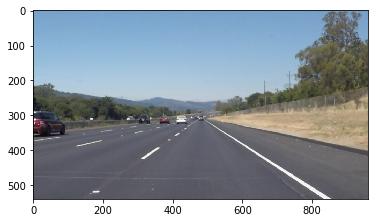

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math
import cv2
import numpy as np

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[0, 0, 255], thickness=5):
    """
    Original provided code:    
    This function draws `lines` with `color` and `thickness`.  
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    """
    """
    Edited code below
    HoughLinesP output is line segments, where all you have is two points on the line

    Need to either average the lines if there are many dashes detected for the lane
    Or extrapolate them if there are some partially detected lines
    Can ignore the vertical line (denominator in slope 0)
    using a linear model (y=mx+c), use the direction of slope to determine which side the line is from
    Left Lane: Potitive gradient  - As the values of column co-ordinate increases, the values of rows co-ordinate decreases. 
    Right Lane: Negative gradient - As the values of column co-ordinate increases, the values of rows co-ordinate increases. 
    Technically they should give roughly the same gradient, with one being negative (for straight lines, not corners)
        
    Have detected two left lanes and two right lanes (either side of the lane)
    Will construct a global left and right lane
    Use use the y intercept to extrapolate the line to the edge pixel

     """

    imshape = img.shape
    
    #Global variables y-axis coordinates -- for extrapolating
    #shape attribute for numpy arrays returns the dimensions of the array. 
    #So .shape[0] is n rows, first dimension of your array.
    global_ymin = img.shape[0]
    global_ymax = img.shape[0]

    # right lane line variables
    #Creating empty lists
    global_right_grad = []
    global_right_y = []
    global_right_x = []
    
    # left lane line variables
    #Creating empty lists
    global_left_grad = []
    global_left_y = []
    global_left_x = []
    
    #HoughLinesP output gives two points on the line
    #So coordinates we have are x1,y1 and x2, y2
    for line in lines:
        for x1,y1,x2,y2 in line:
            gradient, intercept = np.polyfit((x1,x2), (y1,y2), 1)
            global_ymin = min(min(y1, y2), global_ymin)
            
            #Separating the coordinates to their left and right lanes
            #Left Lane: Potitive gradient
            if (gradient > 0):
                global_left_grad += [gradient]
                global_left_y += [y1, y2]
                global_left_x += [x1, x2]
            #Right Lane: Negative gradient
            else:
                global_right_grad += [gradient]
                global_right_y += [y1, y2]
                global_right_x += [x1, x2]
    
    # if no valid line exists,return without further operations
    #if len(global_left_grad) == 0 or len(global_right_grad) == 0:
    #    print("No valid lines are detected")
    #    return
    
    #Creating the global left lane with the average of the points
    left_mean_grad = np.mean(global_left_grad)
    left_y_mean = np.mean(global_left_y)
    left_x_mean = np.mean(global_left_x)
    
    #Calculating the yintercepts
    #Using the linear model y = mx+c 
    left_intercept = left_y_mean - (left_mean_grad * left_x_mean)
    
    #Creating the global right lane with the average of the points
    right_mean_grad = np.mean(global_right_grad)
    right_y_mean = np.mean(global_right_y)
    right_x_mean = np.mean(global_right_x)
    
    #Calculating the yintercepts
    right_intercept = right_y_mean - (right_mean_grad * right_x_mean)
    
    #Checking if there are points in each variable 
    #Finding the top and bottom points
    if ((len(global_left_grad) > 0) and (len(global_right_grad) > 0)):
        upper_left_x = int((global_ymin - left_intercept) / left_mean_grad)
        lower_left_x = int((global_ymax - left_intercept) / left_mean_grad)
        upper_right_x = int((global_ymin - right_intercept) / right_mean_grad)
        lower_right_x = int((global_ymax - right_intercept) / right_mean_grad)
        
        #Drawing the left and right lines using top and bottom points
        cv2.line(img, (upper_left_x, global_ymin), (lower_left_x, global_ymax), color, thickness)
        cv2.line(img, (upper_right_x, global_ymin), (lower_right_x, global_ymax), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

In [4]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

#Already included relevant import packages above

#Parameters definition
low_threshold = 50
high_threshold = 150
kernel_size = 7
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 160     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 10 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments


# image processing pipeline function
def pipeline(image):
    plt.imshow(image)  #plot original image
    initial_img = np.copy(image)*0 # creating a blank to draw lines on

    #from PipelineFunctions import grayscale, gaussian blur and canny functions on the whole image
    gray = Functions.grayscale(image)
    plt.imshow(gray, cmap='gray')  #grayscale image
    gaussian_blur = Functions.gaussian_blur(gray, kernel_size)
    plt.imshow(gaussian_blur)
    edges = Functions.canny(gaussian_blur, low_threshold, high_threshold)
    plt.imshow(edges)   #plots binary image 

    # dilate()ing edge image. 
    #This will make the lines thicker which will help fit the Hough lines better
    dilated = cv2.dilate(edges, np.ones((3,3), dtype=np.uint8))
    plt.imshow(dilated)

    #Cropping the image to within the region of interest
    #imshape = image.shape
    #vertices = np.array([[(140,imshape[0]),(440, 325), (520, 325), (960,imshape[0])]], dtype=np.int32)
    vertices = np.array([[(140,550),(440, 325), (550, 325), (920,550)]], dtype=np.int32)
    #the co-ordinate origin in the image is top-left corner of image
    
    # create a masked edges image
    masked_image = Functions.region_of_interest(dilated, vertices)
    plt.imshow(masked_image)    #plots binary image with lines within boundary    
    #Shows the region
    #x, y = vertices.T
    #plt.plot(x, y, 'b--', lw=4)
    
    #Detecting shape edges in the remaining (cropped) image data
    #Applying the hough transform
    hough_img = Functions.hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)

    #Testing output of hough_img
    #print(hough_img.shape)
    #print(hough_img)
    #for i in range(hough_img.shape[0]):
    #    for j in range(hough_img.shape[1]):
    #        for k in range(3):
    #            if hough_img[i,j,k] > 1e-4:
    #                print(i,j,k,hough_img[i,j,k])
    
    plt.imshow(hough_img)       #Prints full binary image with red lines only
    weighted_img = Functions.weighted_img(hough_img,image, α=0.8, β=1.,γ=0.)
    plt.imshow(weighted_img)    #Prints original image with lines highlighted red 
    
    return weighted_img

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
#Ensuring we can read in all the images in the test_images folder
ImagePath = "test_images"
test_imgs = os.listdir(ImagePath)
print(test_imgs)

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


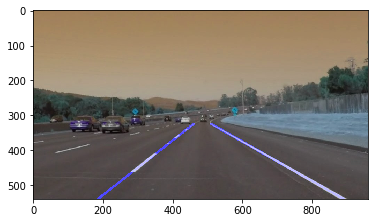

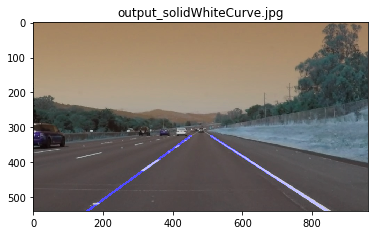

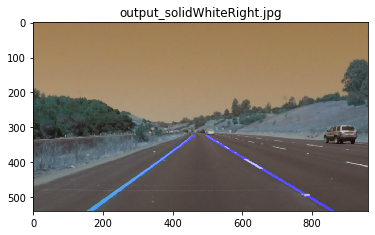

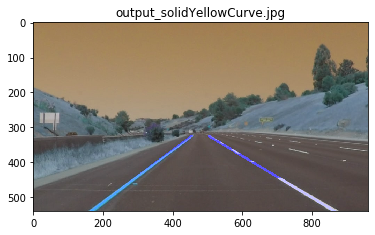

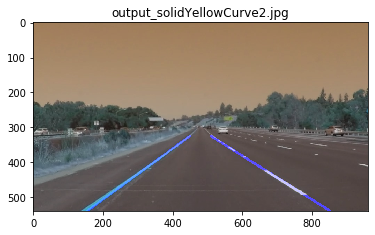

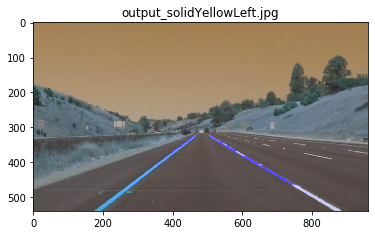

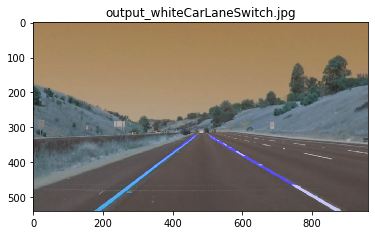

In [6]:
import ProcessImagePipeline as ImageProcess

#'/path/to/folder'
inputpath='C:/Users/lovesa/Desktop/Roadline/Project_Submission/test_images'
outputpath = 'C:/Users/lovesa/Desktop/Roadline/Project_Submission/test_images_output'

#Ensuring we can read in all the images in the test_images folder
#test_imgs = os.listdir(inputpath)
#print(test_imgs)

#This will get all the files in the folder
testfolder = [ f for f in os.listdir(inputpath) if isfile(join(inputpath,f)) ]
images = np.empty(len(testfolder), dtype=object)
#print("There are", len(testfolder), "files in this directory")

#read all files and store them in the array images.
#perform operations to all images in folder

for n in range(0, len(testfolder)):
    image = cv2.imread( join(inputpath,testfolder[n]) )
    #print('This image is number:', n, 'in the sequence',)
    
    #filename = 'output' + str(n) +'.jpg'
    filename = 'output_'+ str(test_imgs[n])
    #print(filename)
    
    final_img = pipeline(image)
    fig = plt.figure()
    plt.title(filename)
    plt.imshow(final_img)
    
    #Save images to the test_images_output directory
    # Change the current directory to specified directory  
    os.chdir(outputpath) 

    cv2.imwrite(filename, final_img)     #saving weighted lines overlay image on original

    if cv2.waitKey(0) & 0xFF == ord('q'):
        break
    
    #Break out of the loop    
   # else:
   #     break
    
cv2.destroyAllWindows()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#import imageio

#pip install imageio-ffmpeg

#import moviepy.editor as mpy

In [8]:
#def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

   # return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'C:/Users/lovesa/Desktop/Roadline/Project_Submission/test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("C:/Users/lovesa/Desktop/Roadline/Project_Submission/test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
import ProcessImagePipeline as ImageProcess

#Create videocapture object and read the input video file
video = cv2.VideoCapture('C:/Users/lovesa/Desktop/Roadline/Project_Submission/test_videos/solidWhiteRight.mp4',0)

#Error checking
#Check if the camera opened successfully 
if(video.isOpened()==False):
    print("Error opening the video stream file")

# Obtaining the default resolutions of the frame - system dependent.
# Convert the resolutions from float to integer.
frame_width = int(video.get(3))
frame_height = int(video.get(4))
fps = (video.get(cv2.CAP_PROP_FPS))

### Write to the video file ###
# Define the codec and create VideoWriter object.
# Define the fps, in this case equal to 10. frame size is also another parameter.
#The output is stored in 'outpy.avi' file.
#MJPG is chosen as the FourCC
 
#VideoWriter(const String &filename, int fourcc, double fps, Size frameSize, bool isColor=true)

outputVideo = cv2.VideoWriter('outputVideoSL.avi',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height),isColor=False)

#Read until the video is completed
while(video.isOpened()):
    #Capture frame by frame
    ret, frame = video.read()
    
    if ret == True:

        output = pipeline(frame)
        cv2.imshow('frame',output)
        
        #Exit if Q is pressed
        #wait time in milliseconds each frame is displayed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    else:
        break

# Release everything if job is finished
#Release the video capture and video write objects
video.release()     
outputVideo.release()
 #Close all frames
cv2.destroyAllWindows() 

No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are detected
No valid lines are d

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


Write up submission here on https://github.com/SamaraLove/Project-1-Lane-Following/blob/master/writeup_template.md

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

Moviepy - Building video C:/Users/lovesa/Desktop/Roadline/Project_Submission/test_videos_output/challenge.mp4.


Moviepy - Writing video C:/Users/lovesa/Desktop/Roadline/Project_Submission/test_videos_output/challenge.mp4



t:  54%|████████████████████████████████████▍                               | 67/125 [00:23<00:20,  2.81it/s, now=None]


t:  86%|█████████████████████████████████████████████████████████▎         | 107/125 [00:38<00:07,  2.34it/s, now=None]

OverflowError: Python int too large to convert to C long

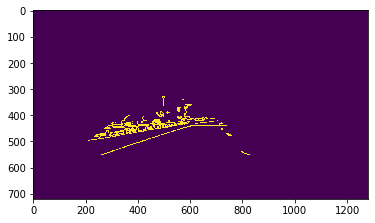

In [14]:
challenge_output = 'C:/Users/lovesa/Desktop/Roadline/Project_Submission/test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('C:/Users/lovesa/Desktop/Roadline/Project_Submission/test_videos/challenge.mp4').subclip(0,5)
challenge_clip = clip3.fl_image(pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))